# Analysis Of Datasets



In [42]:
pip install xgboost

     |████████████████████████████████| 1.8 MB 7.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
#import libraries

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold


In [14]:
# functions
# Rate  = Formation - Cessation
# So this gives rates for all the dates and industries
def find_formation_cessation_rate(formation, cessation):
    
    df = (formation.iloc[:,2 :] - cessation.iloc[:,2 :]).T
    df.columns = cessation["Data Series"].values
    return df
def success_rate(formation, cessation):
    
    temp = (( (formation.iloc[:,2 :] - cessation.iloc[:,2 :])/formation.iloc[:,2 :])*100 ).T
    temp.columns = cessation["Data Series"].values
    
    temp = temp.mean(axis = 1).sort_values(ascending = False)
    
    display(temp)
    
    
    # This is the average rate across all the years
    sb.barplot(x = temp.index, y = temp);
    plt.xticks(rotation = 90);
    plt.title("Cessation-Formation Rate Vs Industry");
    plt.xlabel("Industry:");
    plt.ylabel("Average Rate for Cessation-Formation Rate over the period: '1990-01-01' to '2022-12-01' ");
    plt.show();
    print()
    
def get_data_date_wise(data):
    
    df = data.iloc[:,2 :].T
    df.columns = data["Data Series"].values
    return df


# We would be taking a mean across all the dates 
def aggregate_cessation_formation(df, title):
    temp = df.mean(axis = 1).sort_values(ascending = False)
    display(temp)
    
    
    # This is the average rate across all the years
    sb.barplot(x = temp.index, y = temp);
    plt.xticks(rotation = 90);
    plt.title(title);
    plt.xlabel("Industry:");
    plt.ylabel("Average Value over the period: '1990-01-01' to '2022-12-01' ");
    plt.show();
    print()
    
    print("The rate is maximum for the industry: ", temp.index[0])
    print("The rate is minimum for the industry: ", temp.index[-1])
    print()

def plot_line_plots(df):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(10, 10))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

    index = 0
    for col in range(0, df.shape[0], 3):
        axes[index].plot(df.reset_index().iloc[col].index[1:],  df.reset_index().iloc[col].values[1:])
        axes[index].tick_params(axis='x', rotation=90)
        axes[index].title.set_text(df.iloc[col].name)

        axes[index+1].plot(df.reset_index().iloc[col+1].index[1:],  df.reset_index().iloc[col+1].values[1:])
        axes[index+1].tick_params(axis='x', rotation=90)
        axes[index+1].title.set_text(df.iloc[col+1].name)

        axes[index+2].plot(df.reset_index().iloc[col+2].index[1:],  df.reset_index().iloc[col+2].values[1:])
        axes[index+2].tick_params(axis='x', rotation=90)
        axes[index+2].title.set_text(df.iloc[col+2].name)

        plt.xticks(rotation = 90);
        index+=3    
    plt.tight_layout(pad=0.8)


In [3]:
# Read files

Covid_Formation = pd.read_csv("Covid_Formation.csv", parse_dates=["Data Series"])
Cessation_Cleaned = pd.read_csv("Cessation_Cleaned.csv", parse_dates=["Data Series"])
Formation_Cleaned = pd.read_csv("Formation_Cleaned.csv", parse_dates=["Data Series"])
Covid_Cessation = pd.read_csv("Covid_Cessation.csv", parse_dates=["Data Series"])


Cessation_Cleaned = Cessation_Cleaned.sort_values("Data Series", ascending = True).reset_index(drop = True)
Formation_Cleaned = Formation_Cleaned.sort_values("Data Series", ascending = True).reset_index(drop = True)
Covid_Cessation = Covid_Cessation.sort_values("Data Series", ascending = True).reset_index(drop = True)
Covid_Formation = Covid_Formation.sort_values("Data Series", ascending = True).reset_index(drop = True)

In [4]:
Cessation_df = Cessation_Cleaned.copy()
Formation_df = Formation_Cleaned.copy()
Covid_Cessation_df = Covid_Cessation.copy()
Covid_Formation_df = Covid_Formation.copy()

Formation_df.columns = ["Formation_" + col for col in Formation_df.columns]
Cessation_df.columns = ["Cessation_" + col for col in  Cessation_df.columns]
Covid_Formation_df.columns = ["Covid_Formation_" + col for col in Covid_Formation_df.columns]
Covid_Cessation_df.columns = ["Covid_Cessation_" + col for col in  Covid_Cessation_df.columns]

In [5]:
# For a partcular date a row has been recorded and there is no repetition 
(Cessation_df["Cessation_Data Series"].nunique(), Cessation_Cleaned.shape[0],
Formation_df["Formation_Data Series"].nunique(), Formation_df.shape[0],
Covid_Cessation_df["Covid_Cessation_Data Series"].nunique(), Covid_Cessation_df.shape[0],
Covid_Formation_df["Covid_Formation_Data Series"].nunique(), Covid_Formation_df.shape[0])

(396, 396, 396, 396, 36, 36, 36, 36)

In [6]:
cessation_formation = pd.merge(Formation_df, Cessation_df, how='inner', left_on='Formation_Data Series', right_on='Cessation_Data Series')
covid_cessation_formation = pd.merge(Covid_Formation_df, Covid_Cessation_df, how='inner', left_on='Covid_Formation_Data Series', right_on='Covid_Cessation_Data Series')

In [7]:
# Check if the colums and order are same
Formation_Cleaned.iloc[:,2 :].columns == Cessation_Cleaned.iloc[:,2 :].columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [8]:
daily_rates_cess_form = find_formation_cessation_rate(Formation_Cleaned, Cessation_Cleaned)
daily_rates_cess_form

,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,1990-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Manufacturing,26,95,96,29,108,25,31,65,96,94,...,62,-18,27,-4,0,30,7,8,64,11
Construction,-9,89,84,76,96,32,52,117,98,109,...,131,71,12,141,28,78,58,49,57,94
Wholesale Trade,193,225,272,307,264,145,190,341,259,302,...,-36,-42,-18,34,-18,148,27,86,83,150
Retail Trade,-9,51,109,47,109,58,7,139,58,119,...,17,-171,-98,-129,3,-1,-61,-148,-118,-74
Transportation & Storage,63,64,62,31,48,51,58,93,39,76,...,-23,-60,-73,-66,-68,-17,-54,-63,-37,-43
Accommodation,2,1,0,0,1,3,-2,1,-1,0,...,1,-2,-3,3,-4,15,-3,1,-4,-2
Food & Beverage Services,1,31,17,-1,19,2,-4,24,-6,50,...,94,56,27,131,89,50,76,5,-42,5
Information & Communications,4,33,42,29,29,25,33,32,36,33,...,476,305,319,337,297,377,288,262,313,290
Finance & Insurance,24,33,62,57,52,68,49,33,49,39,...,450,513,328,473,431,463,429,237,410,389
Real Estate,38,46,43,21,57,39,22,51,25,29,...,30,27,17,1,5,6,33,24,16,9


Professional Services                               196.664141
Finance & Insurance                                 144.214646
Wholesale Trade                                     134.058081
Information & Communications                        116.553030
Education, Health & Social Services                  69.611111
Retail Trade                                         59.199495
Arts, Entertainment, Recreation & Other Services     53.729798
Transportation & Storage                             48.881313
Food & Beverage Services                             47.434343
Construction                                         46.345960
Administrative & Support Services                    46.075758
Manufacturing                                        18.762626
Real Estate                                          10.398990
Others                                                5.431818
Accommodation                                         1.959596
dtype: float64

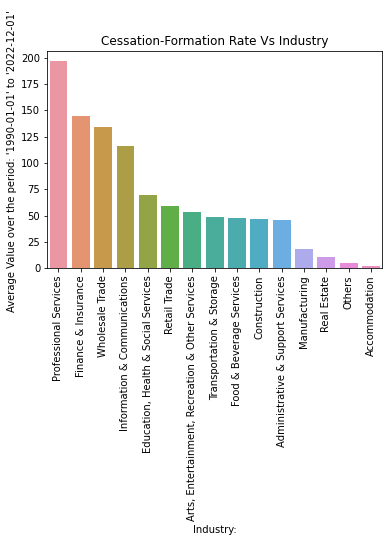


The rate is maximum for the industry:  Professional Services
The rate is minimum for the industry:  Accommodation



In [15]:
aggregate_cessation_formation(daily_rates_cess_form, "Cessation-Formation Rate Vs Industry")


In [18]:
# We have found out the rate here but this is for every day, we need to find mean of rates
covid_df = find_formation_cessation_rate(Covid_Formation, Covid_Cessation)
covid_df

,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Manufacturing,19,-2,55,-19,31,82,135,192,63,154,...,62,-18,27,-4,0,30,7,8,64,11
Construction,12,49,32,-56,-66,-23,25,153,61,179,...,131,71,12,141,28,78,58,49,57,94
Wholesale Trade,193,81,232,12,106,378,538,1027,213,648,...,-36,-42,-18,34,-18,148,27,86,83,150
Retail Trade,54,-17,93,199,304,616,571,746,458,659,...,17,-171,-98,-129,3,-1,-61,-148,-118,-74
Transportation & Storage,-76,-117,-92,-74,-135,-2,-8,134,-75,68,...,-23,-60,-73,-66,-68,-17,-54,-63,-37,-43
Accommodation,0,1,-2,-2,-2,-5,-3,4,1,0,...,1,-2,-3,3,-4,15,-3,1,-4,-2
Food & Beverage Services,7,28,25,-20,-11,64,127,262,151,325,...,94,56,27,131,89,50,76,5,-42,5
Information & Communications,187,135,118,95,-113,156,121,636,-45,394,...,476,305,319,337,297,377,288,262,313,290
Finance & Insurance,285,259,267,61,109,197,260,441,154,461,...,450,513,328,473,431,463,429,237,410,389
Real Estate,2,5,7,-40,-30,-3,-3,33,-4,74,...,30,27,17,1,5,6,33,24,16,9


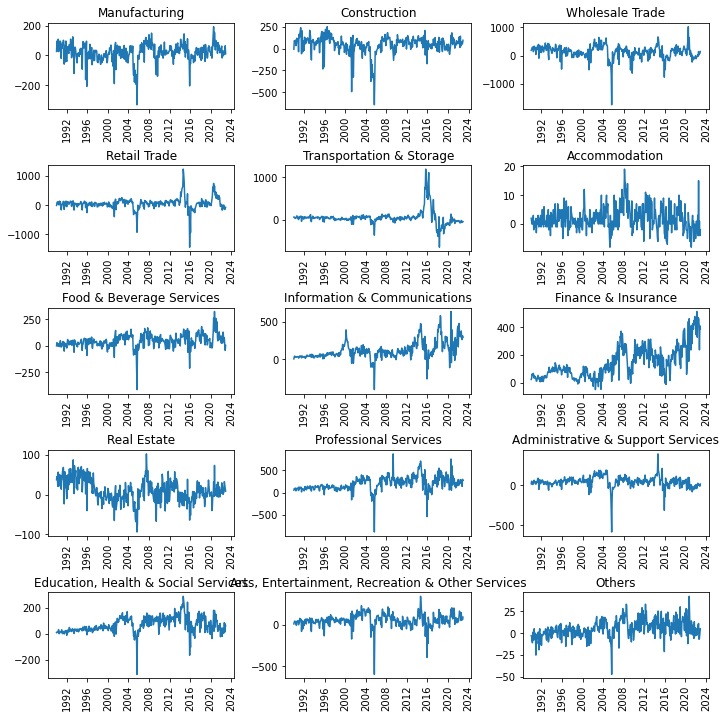

In [17]:
plot_line_plots(daily_rates_cess_form)

Finance & Insurance                                 354.027778
Professional Services                               247.916667
Information & Communications                        228.277778
Retail Trade                                        184.361111
Wholesale Trade                                      97.055556
Food & Beverage Services                             91.750000
Arts, Entertainment, Recreation & Other Services     83.694444
Construction                                         60.611111
Education, Health & Social Services                  56.194444
Manufacturing                                        50.194444
Real Estate                                           9.416667
Others                                                6.361111
Accommodation                                        -1.305556
Administrative & Support Services                    -3.916667
Transportation & Storage                            -35.805556
dtype: float64

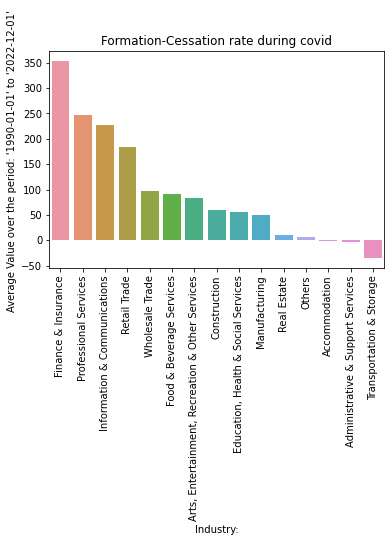


The rate is maximum for the industry:  Finance & Insurance
The rate is minimum for the industry:  Transportation & Storage



In [19]:
aggregate_cessation_formation(covid_df, "Formation-Cessation rate during covid")

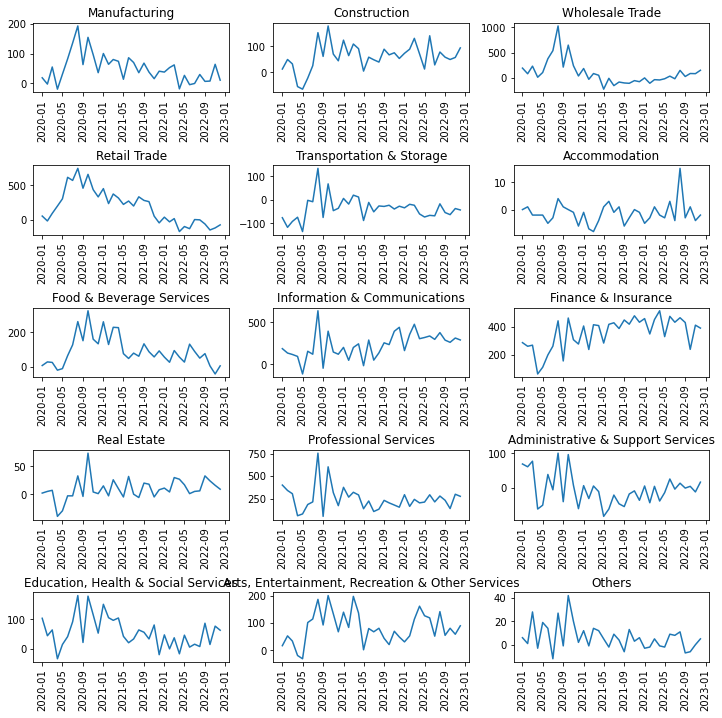

In [20]:
plot_line_plots(covid_df)


In [24]:
cessation_df_datewise = get_data_date_wise(Cessation_Cleaned)
cessation_df_datewise


,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,1990-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Manufacturing,142,117,152,146,129,166,150,141,97,101,...,164,221,171,200,190,186,185,184,168,186
Construction,156,127,155,126,137,173,166,103,95,107,...,184,197,247,165,208,213,232,202,209,153
Wholesale Trade,343,323,396,320,366,439,396,335,294,310,...,753,765,769,720,826,764,828,743,818,654
Retail Trade,216,210,216,217,216,255,291,187,194,231,...,487,547,477,513,469,524,516,553,528,496
Transportation & Storage,56,48,64,73,61,70,59,54,50,47,...,261,280,280,295,286,260,280,281,253,215
Accommodation,2,1,1,1,1,0,2,1,2,0,...,4,4,8,4,13,4,11,2,10,5
Food & Beverage Services,51,43,66,68,65,76,78,42,50,36,...,216,245,233,172,213,245,246,284,275,209
Information & Communications,20,16,19,10,18,12,21,17,19,17,...,382,424,415,426,426,479,455,429,464,403
Finance & Insurance,27,24,20,13,21,20,32,19,25,30,...,270,305,282,225,305,240,294,355,293,289
Real Estate,28,23,33,41,29,39,38,33,32,26,...,48,47,49,49,46,53,47,51,44,47


Wholesale Trade                                     630.752525
Retail Trade                                        360.729798
Professional Services                               345.106061
Construction                                        211.121212
Arts, Entertainment, Recreation & Other Services    191.383838
Information & Communications                        181.252525
Transportation & Storage                            177.654040
Manufacturing                                       167.851010
Administrative & Support Services                   150.603535
Food & Beverage Services                            146.606061
Finance & Insurance                                 139.045455
Education, Health & Social Services                 113.886364
Real Estate                                          56.522727
Others                                               16.146465
Accommodation                                         4.108586
dtype: float64

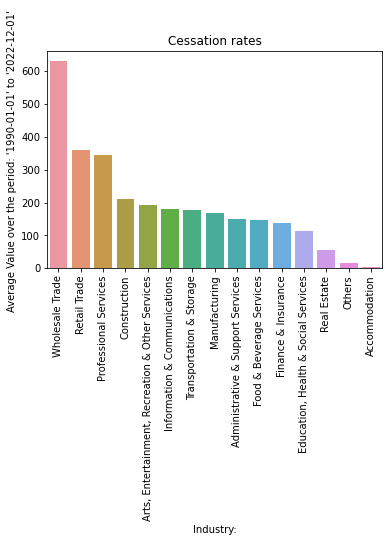


The rate is maximum for the industry:  Wholesale Trade
The rate is minimum for the industry:  Accommodation



In [22]:
aggregate_cessation_formation(cessation_df_datewise, "Cessation rates")


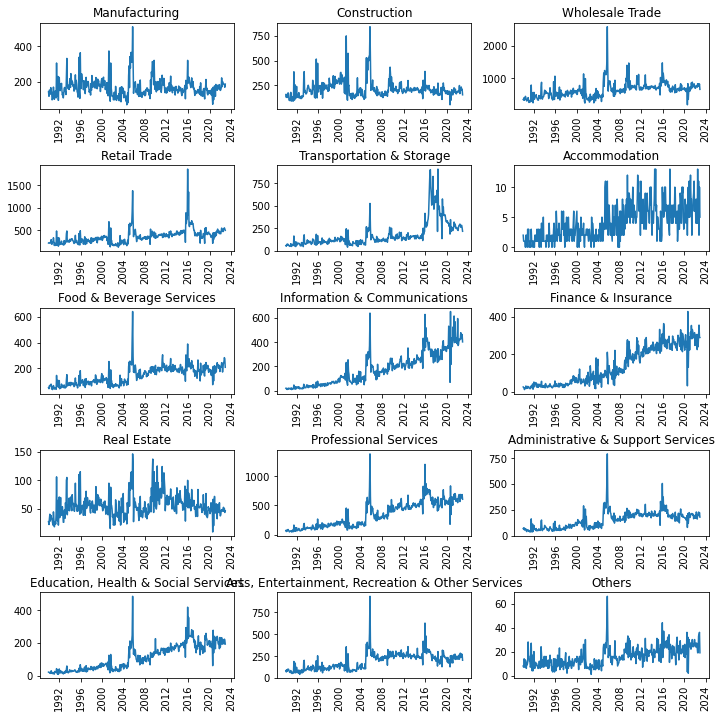

In [23]:
plot_line_plots(cessation_df_datewise)


In [25]:
formation_df_datewise = get_data_date_wise(Formation_Cleaned)
formation_df_datewise

,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,1990-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Manufacturing,168,212,248,175,237,191,181,206,193,195,...,226,203,198,196,190,216,192,192,232,197
Construction,147,216,239,202,233,205,218,220,193,216,...,315,268,259,306,236,291,290,251,266,247
Wholesale Trade,536,548,668,627,630,584,586,676,553,612,...,717,723,751,754,808,912,855,829,901,804
Retail Trade,207,261,325,264,325,313,298,326,252,350,...,504,376,379,384,472,523,455,405,410,422
Transportation & Storage,119,112,126,104,109,121,117,147,89,123,...,238,220,207,229,218,243,226,218,216,172
Accommodation,4,2,1,1,2,3,0,2,1,0,...,5,2,5,7,9,19,8,3,6,3
Food & Beverage Services,52,74,83,67,84,78,74,66,44,86,...,310,301,260,303,302,295,322,289,233,214
Information & Communications,24,49,61,39,47,37,54,49,55,50,...,858,729,734,763,723,856,743,691,777,693
Finance & Insurance,51,57,82,70,73,88,81,52,74,69,...,720,818,610,698,736,703,723,592,703,678
Real Estate,66,69,76,62,86,78,60,84,57,55,...,78,74,66,50,51,59,80,75,60,56


Finance & Insurance                                 50.176820
Information & Communications                        41.105687
Education, Health & Social Services                 39.721610
Professional Services                               38.374956
Administrative & Support Services                   23.279183
Food & Beverage Services                            21.825709
Arts, Entertainment, Recreation & Other Services    21.333087
Wholesale Trade                                     16.897559
Transportation & Storage                            15.652792
Construction                                        14.586423
Retail Trade                                         9.251670
Manufacturing                                        7.332252
Others                                               6.050093
Real Estate                                          5.346710
Accommodation                                            -inf
dtype: float64

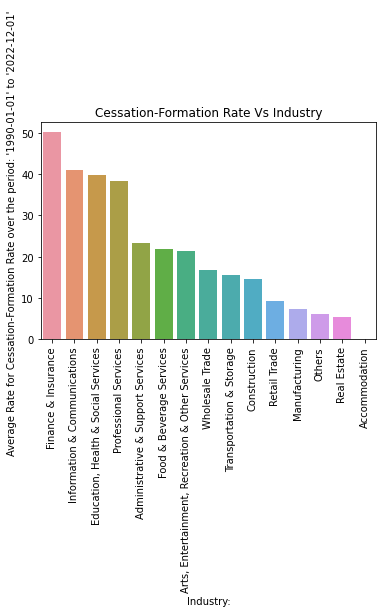

In [26]:
success_rate(Formation_Cleaned, Cessation_Cleaned)

Wholesale Trade                                     764.810606
Professional Services                               541.770202
Retail Trade                                        419.929293
Information & Communications                        297.805556
Finance & Insurance                                 283.260101
Construction                                        257.467172
Arts, Entertainment, Recreation & Other Services    245.113636
Transportation & Storage                            226.535354
Administrative & Support Services                   196.679293
Food & Beverage Services                            194.040404
Manufacturing                                       186.613636
Education, Health & Social Services                 183.497475
Real Estate                                          66.921717
Others                                               21.578283
Accommodation                                         6.068182
dtype: float64

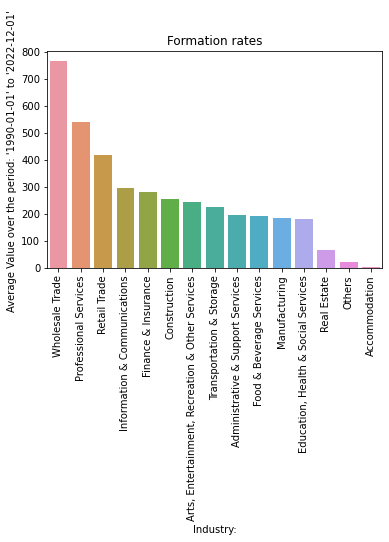


The rate is maximum for the industry:  Wholesale Trade
The rate is minimum for the industry:  Accommodation



In [27]:
aggregate_cessation_formation(formation_df_datewise, "Formation rates")


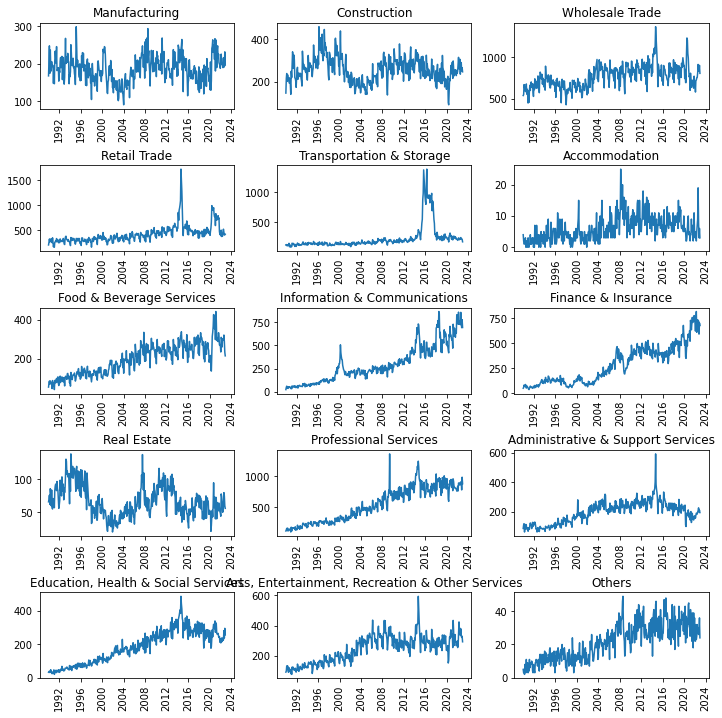

In [28]:
plot_line_plots(formation_df_datewise)


In [29]:
Covid_Cessation_df_datewise = get_data_date_wise(Covid_Cessation)
Covid_Cessation_df_datewise

,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Manufacturing,148,133,150,149,124,159,112,72,168,97,...,164,221,171,200,190,186,185,184,168,186
Construction,193,160,194,158,158,171,189,52,176,98,...,184,197,247,165,208,213,232,202,209,153
Wholesale Trade,706,660,620,681,586,665,694,178,830,342,...,753,765,769,720,826,764,828,743,818,654
Retail Trade,422,416,387,344,364,379,394,209,442,295,...,487,547,477,513,469,524,516,553,528,496
Transportation & Storage,316,332,304,306,304,270,294,184,345,212,...,261,280,280,295,286,260,280,281,253,215
Accommodation,5,5,8,7,4,7,6,2,8,10,...,4,4,8,4,13,4,11,2,10,5
Food & Beverage Services,189,176,191,158,146,173,188,74,215,103,...,216,245,233,172,213,245,246,284,275,209
Information & Communications,360,356,371,349,533,461,474,69,654,217,...,382,424,415,426,426,479,455,429,464,403
Finance & Insurance,245,222,264,304,240,245,269,33,427,131,...,270,305,282,225,305,240,294,355,293,289
Real Estate,51,42,44,61,60,47,56,10,67,21,...,48,47,49,49,46,53,47,51,44,47


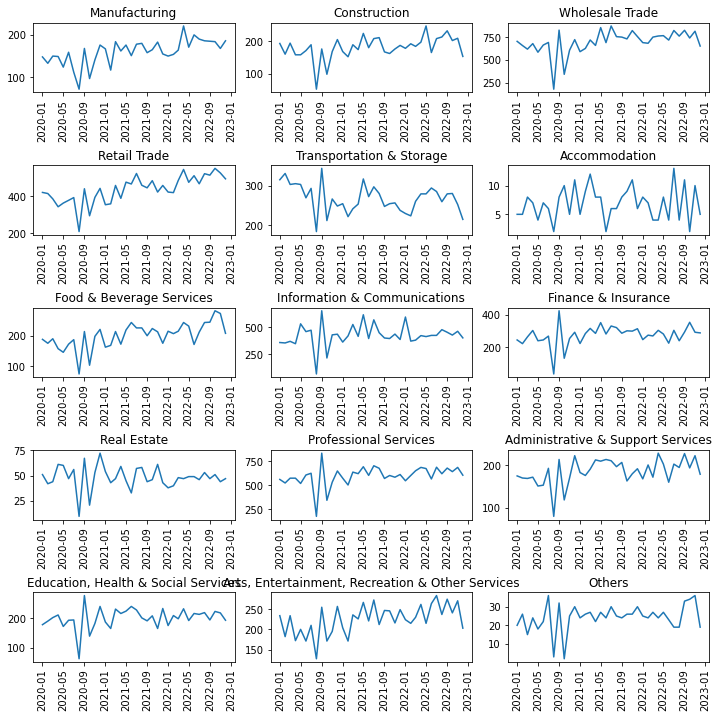

In [30]:
plot_line_plots(Covid_Cessation_df_datewise)


In [32]:
covid_formation_df_datewise = get_data_date_wise(Covid_Formation)
covid_formation_df_datewise
covid_formation_df_datewise.sum(axis = 1)


Manufacturing                                        7571
Construction                                         8682
Wholesale Trade                                     28662
Retail Trade                                        22397
Transportation & Storage                             8380
Accommodation                                         201
Food & Beverage Services                            10554
Information & Communications                        23591
Finance & Insurance                                 22656
Real Estate                                          2072
Professional Services                               30435
Administrative & Support Services                    6538
Education, Health & Social Services                  9270
Arts, Entertainment, Recreation & Other Services    11110
Others                                               1103
dtype: int64

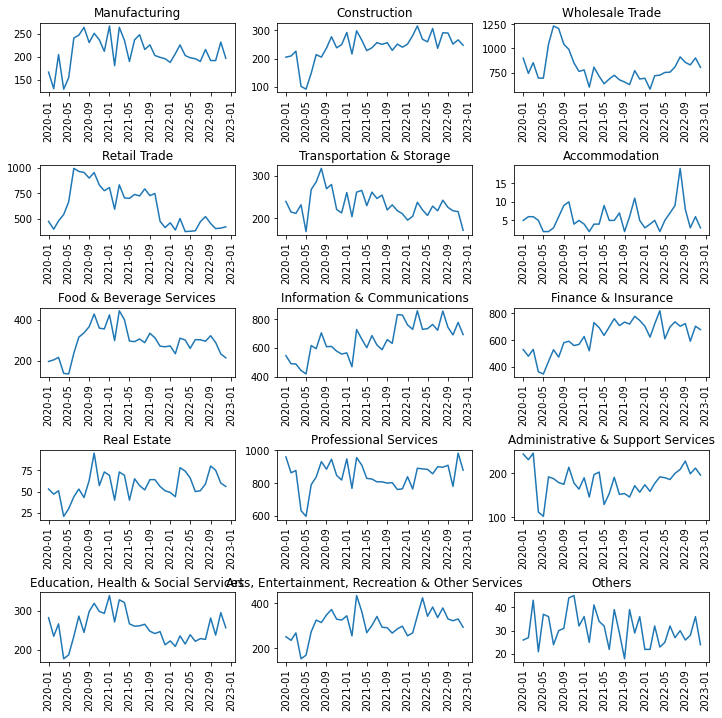

In [33]:
plot_line_plots(covid_formation_df_datewise)


## Try modelling

Modelling the total rate over the years

In [34]:
form_cess_rate = pd.DataFrame( Formation_Cleaned.iloc[:,1 ] - Cessation_Cleaned.iloc[:,1])
form_cess_rate = form_cess_rate.set_index(Formation_Cleaned["Data Series"].values)
form_cess_rate

,Total
1990-01-01,422
1990-02-01,852
1990-03-01,975
1990-04-01,723
1990-05-01,982
...,...
2022-08-01,1601
2022-09-01,1166
2022-10-01,694
2022-11-01,1165


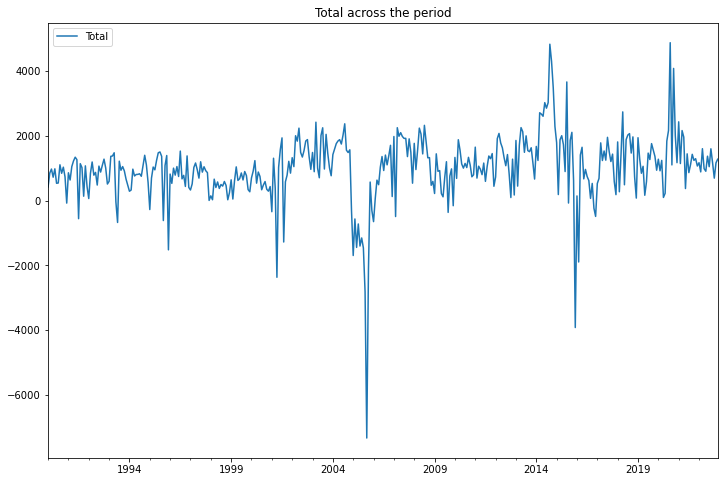

In [35]:
form_cess_rate.columns = ['Total']
form_cess_rate.plot(figsize=(12,8));
plt.title("Total across the period");


In [36]:
form_cess_rate['Total_LastMonth']=form_cess_rate['Total'].shift(+1)
form_cess_rate['Total_2Monthsback']=form_cess_rate['Total'].shift(+2)
form_cess_rate['Total_3Monthsback']=form_cess_rate['Total'].shift(+3)
form_cess_rate

,Total,Total_LastMonth,Total_2Monthsback,Total_3Monthsback
1990-01-01,422,NaN,NaN,NaN
1990-02-01,852,422.0,NaN,NaN
1990-03-01,975,852.0,422.0,NaN
1990-04-01,723,975.0,852.0,422.0
1990-05-01,982,723.0,975.0,852.0
...,...,...,...,...
2022-08-01,1601,1048.0,1372.0,907.0
2022-09-01,1166,1601.0,1048.0,1372.0
2022-10-01,694,1166.0,1601.0,1048.0
2022-11-01,1165,694.0,1166.0,1601.0


In [37]:
form_cess_rate = form_cess_rate.dropna()
form_cess_rate

,Total,Total_LastMonth,Total_2Monthsback,Total_3Monthsback
1990-04-01,723,975.0,852.0,422.0
1990-05-01,982,723.0,975.0,852.0
1990-06-01,535,982.0,723.0,975.0
1990-07-01,544,535.0,982.0,723.0
1990-08-01,1107,544.0,535.0,982.0
...,...,...,...,...
2022-08-01,1601,1048.0,1372.0,907.0
2022-09-01,1166,1601.0,1048.0,1372.0
2022-10-01,694,1166.0,1601.0,1048.0
2022-11-01,1165,694.0,1166.0,1601.0


In [38]:
form_cess_rate.columns

Index(['Total', 'Total_LastMonth', 'Total_2Monthsback', 'Total_3Monthsback'], dtype='object')

In [39]:
x1,x2,x3,y=form_cess_rate['Total_LastMonth'],form_cess_rate['Total_2Monthsback'],form_cess_rate['Total_3Monthsback'],form_cess_rate['Total']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
X = np.concatenate((x1,x2,x3),axis=1)
print(X)
     

[[ 975.  852.  422.]
 [ 723.  975.  852.]
 [ 982.  723.  975.]
 ...
 [1166. 1601. 1048.]
 [ 694. 1166. 1601.]
 [1165.  694. 1166.]]


In [45]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size = 0.2)

## Decision Tree Regressor


In [50]:
def train_model(model, X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    
    
    rmse_model=sqrt(mean_squared_error(pred,y_test))

    print('Mean Squared Error for Model is:',rmse_model)


    plt.rcParams["figure.figsize"] = (12,8)
    plt.plot(pred,label='Model Total')
    plt.plot(y_test,label='Actual Total')
    plt.legend(loc="upper left")
    plt.show()

Mean Squared Error for Model is: 1221.9140411872813


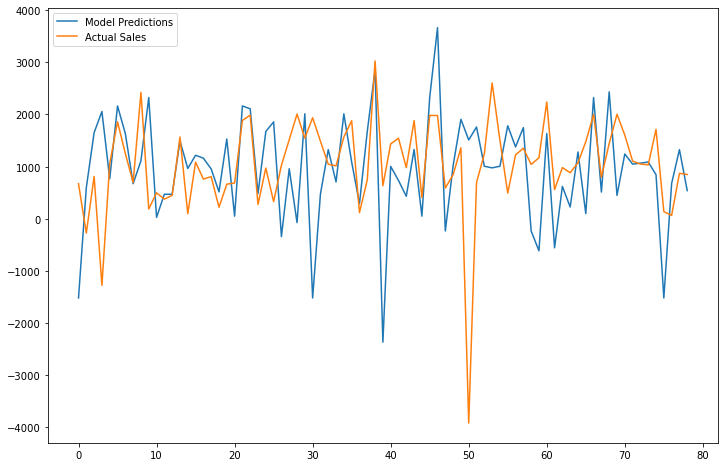

In [49]:
train_model(DecisionTreeRegressor(), X_train,X_test,y_train,y_test)

Tuning hyper parameter of decision tree


In [51]:
def gridsearchit(reg, grid, X_train, X_test, y_train, y_test):
    grid_ = GridSearchCV(estimator = reg, param_grid = grid, cv = 2, n_jobs=4, verbose = 0, scoring='r2')
    grid_.fit(X_train, y_train)
    print(f"Results from Grid Search: " )
    print(f"\nThe best estimator across ALL searched params for {str(reg).split('(')[0]}\n", grid_.best_estimator_)
    print(f"\nThe best score across ALL searched params for {str(reg).split('(')[0]}", grid_.best_score_)
    print(f"\nThe best parameters across ALL searched params for {str(reg).split('(')[0]}:\n", grid_.best_params_)
    print()
    # Getting the best estimator
    optimized_model = grid_.best_estimator_
    return optimized_model

    
dt_grid = { 'max_depth' : np.arange(1, 25)  }


dt_opt = gridsearchit(DecisionTreeRegressor(), dt_grid, X_train, X_test, y_train, y_test)

Results from Grid Search: 

The best estimator across ALL searched params for DecisionTreeRegressor
 DecisionTreeRegressor(max_depth=4)

The best score across ALL searched params for DecisionTreeRegressor 0.2490826695236395

The best parameters across ALL searched params for DecisionTreeRegressor:
 {'max_depth': 4}



Xgboost

Mean Squared Error for Model is: 1030.8719902438231


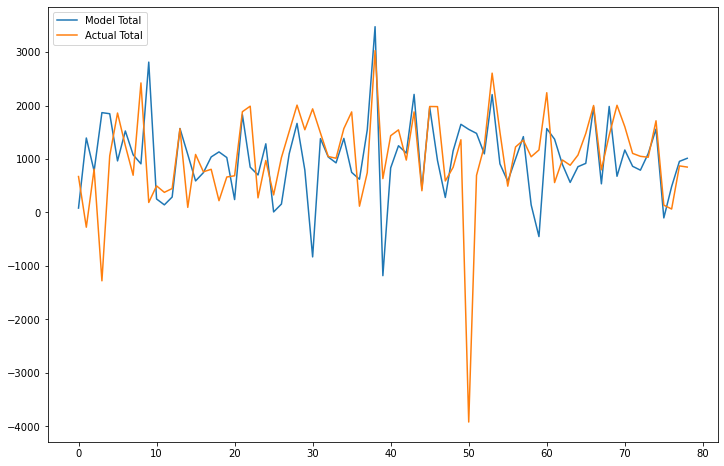

In [52]:
train_model(xgboost.XGBRegressor(random_state=1), X_train,X_test,y_train,y_test)

Tuning hyperparameter for xgboost

In [53]:
# A parameter grid for XGBoost
xgb_grid = { 'max_depth': [5,6,7,8, 9],
                 'learning_rate' : [0.01,0.02,0.03],
                  'num_iterations'    : [100, 200, 500, 1000]
                 }

xgb_opt = gridsearchit(xgboost.XGBRegressor(random_state=1), xgb_grid, X_train, X_test, y_train, y_test)

[23:18:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Results from Grid Search: 

The best estimator across ALL searched params for XGBRegressor
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_iterations=100,
             num_parallel_tree=None, pr

[23:18:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Mean Squared Error for Model is: 911.4212183241739


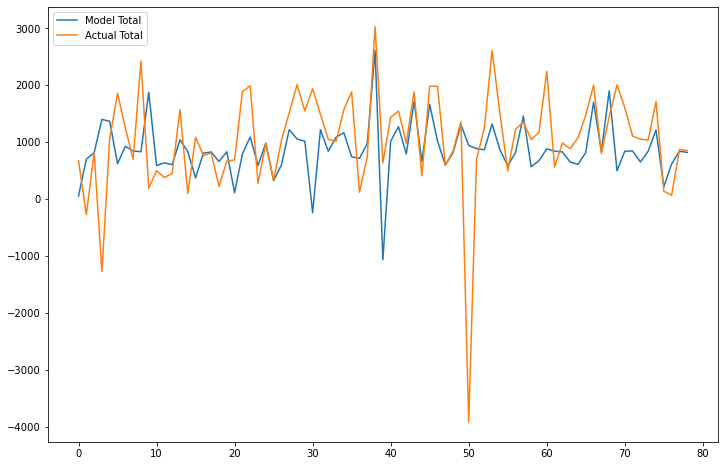

In [54]:
train_model(xgb_opt, X_train,X_test,y_train,y_test)


So after tuning hyperparameters the rmse has reduced.
